The goal is to identify which customers contribute the most financially.

In [2]:
#%load_ext nb_black

# Library to suppress warnings or deprecation notes
!pip install scikit-learn
!pip install geopy
!pip install folium
!pip install pdfkit
!pip install geopandas

import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.manifold import TSNE
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import math
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
import datetime
from sklearn.impute import KNNImputer
import plotly.express as px
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy import stats
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.metrics import make_scorer, silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram
from sklearn.model_selection import GridSearchCV

In [4]:
df_value_based = pd.read_csv("df_ready_for_clustering.csv")
df_value_based.head()

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,LoyaltyIndex,HasBonus,TotalFlights,sr_jan,sr_feb,...,CustomerSegment_Moderate traveler and high redeemed,CustomerSegment_Moderate traveler and low redeemed,Education_College,Education_Doctor,Education_High School or Below,Education_Master,Marital Status_Married,Marital Status_Single,LoyaltyStatus_Nova,LoyaltyStatus_Star
0,0.011660,0.200000,0.053732,0.101416,0.497569,0.053931,0.0,0.655977,0.026667,0.040000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.016634,0.224490,0.031560,0.071096,0.232192,0.031779,0.0,0.714286,0.077551,0.024490,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.003408,0.241706,0.046686,0.347041,0.587235,0.046867,0.0,0.615160,0.094787,0.000000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.010644,0.157407,0.076975,0.111097,0.361054,0.077074,0.0,0.314869,0.000000,0.111111,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.007622,0.276243,0.054122,0.155144,0.491619,0.054280,0.0,0.527697,0.022099,0.027624,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
df_value_based.columns

Index(['PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'LoyaltyIndex', 'HasBonus', 'TotalFlights', 'sr_jan', 'sr_feb',
       'sr_mar', 'sr_apr', 'sr_may', 'sr_jun', 'sr_jul', 'sr_aug', 'sr_sep',
       'sr_oct', 'sr_nov', 'sr_dec', 'Province or State', 'Income',
       'EnrollmentMonth', 'Time on Program', 'Cancelled', 'Reenroll',
       'EnrollmentType', 'Customer Lifetime Value',
       'CustomerSegment_Low traveler and low redeemed',
       'CustomerSegment_Moderate traveler and high redeemed',
       'CustomerSegment_Moderate traveler and low redeemed',
       'Education_College', 'Education_Doctor',
       'Education_High School or Below', 'Education_Master',
       'Marital Status_Married', 'Marital Status_Single', 'LoyaltyStatus_Nova',
       'LoyaltyStatus_Star'],
      dtype='object')

In [ ]:
value_features = [

    'Customer Lifetime Value',
    'UnredeemedPoints',
    'PointsRedeemedRatio',
    'KMPerRedeemedPoint',
    'AvgDistancePerFlight',
    'FlightsWithCompanionsRatio',
    'TotalFlights',

    'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun',
    'sr_jul', 'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec'
]

df_value_based = df_value_based[value_features]


,Customer Lifetime Value,UnredeemedPoints,PointsRedeemedRatio,KMPerRedeemedPoint,AvgDistancePerFlight,FlightsWithCompanionsRatio,TotalFlights,sr_jan,sr_feb,sr_mar,sr_apr,sr_may,sr_jun,sr_jul,sr_aug,sr_sep,sr_oct,sr_nov,sr_dec
ValueCluster,,,,,,,,,,,,,,,,,,,
0,0.077392,0.422047,0.008834,0.148070,0.048159,0.244411,0.545199,0.060289,0.059854,0.080464,0.070136,0.085690,0.105322,0.116677,0.100546,0.080236,0.075262,0.070049,0.095199
1,0.066131,0.142412,0.011028,0.048579,0.053823,0.263712,0.192259,0.050039,0.046823,0.060201,0.049087,0.063731,0.079090,0.097241,0.101194,0.097178,0.111755,0.118561,0.125101
2,0.077961,0.000037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.074756,0.034089,0.012882,0.006067,0.065983,0.304659,0.039491,0.000452,0.000259,0.001470,0.000173,0.000137,0.001351,0.000589,0.000525,0.012458,0.023973,0.163800,0.794814


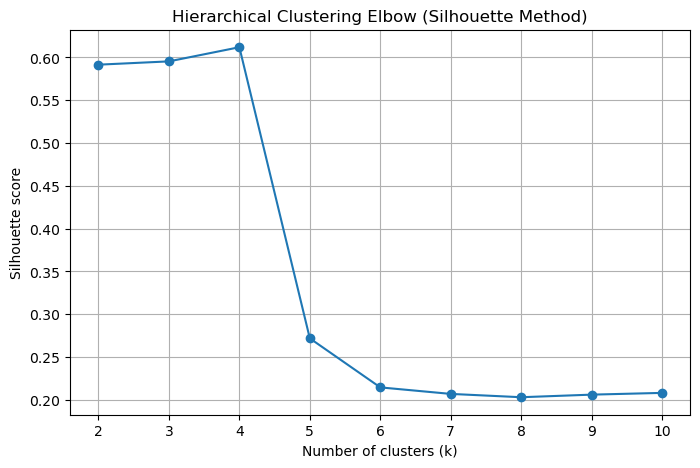

In [10]:
# Range of clusters to test
K = range(2, 11)

sil_scores = []

for k in K:
    model = AgglomerativeClustering(
        n_clusters=k,
        metric='euclidean',
        linkage='ward'
    )
    labels = model.fit_predict(df_value_based)
    sil_scores.append(silhouette_score(df_value_based, labels))

# Plot “elbow”
plt.figure(figsize=(8,5))
plt.plot(K, sil_scores, marker='o')
plt.title("Hierarchical Clustering Elbow (Silhouette Method)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

In [11]:
from sklearn.cluster import AgglomerativeClustering

hc_final = AgglomerativeClustering(
    n_clusters=4,
    metric='euclidean',
    linkage='ward'
)

df_value_based['ValueCluster'] = hc_final.fit_predict(df_value_based)


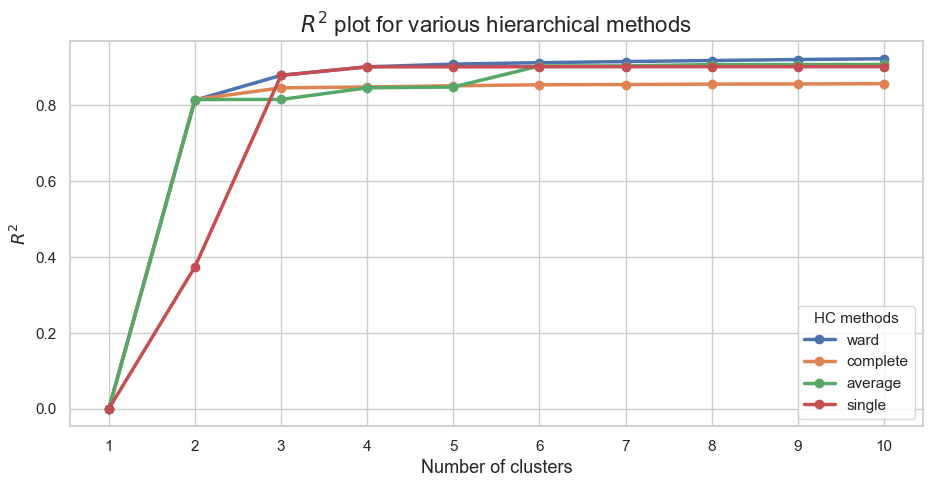

In [ ]:

def get_ss(df, feats):
    """Compute total sum of squares (SST) for features in df."""
    X = df[feats].values
    mean_vec = X.mean(axis=0)
    return ((X - mean_vec)**2).sum()

def get_ssw(df, feats, label_col):
    """Compute sum of squares within clusters (SSW)."""
    X = df[feats].values
    labels = df[label_col].values
    ssw = 0
    for lbl in np.unique(labels):
        cluster_points = X[labels == lbl]
        cluster_mean = cluster_points.mean(axis=0)
        ssw += ((cluster_points - cluster_mean)**2).sum()
    return ssw

def get_rsq(df, feats, label_col):
    """Compute R² for clustering solution."""
    sst = get_ss(df, feats)
    ssw = get_ssw(df, feats, label_col)
    ssb = sst - ssw
    return ssb / sst


def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """Compute R² for a range of cluster solutions."""
    r2 = []
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus + 1):
        cluster = AgglomerativeClustering(
            n_clusters=i,
            metric=dist,
            linkage=link_method
        )
        hclabels = cluster.fit_predict(df[feats])
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)
        r2.append(get_rsq(df_concat, feats, 'labels'))
    
    return np.array(r2)


metric_features = df_value_based.columns.tolist()  # your numeric features for clustering
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

results = []

for link in hc_methods:
    r2 = get_r2_hc(
        df=df_value_based[metric_features],
        link_method=link,
        max_nclus=max_nclus,
        min_nclus=1,
        dist="euclidean"
    )
    results.append(r2)

r2_hc = np.vstack(results)


sns.set(style="whitegrid")
plt.figure(figsize=(11,5))

for i, link in enumerate(hc_methods):
    plt.plot(range(1, max_nclus + 1), r2_hc[i], marker='o', linewidth=2.5, label=link)

plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("$R^2$", fontsize=13)
plt.xticks(range(1, max_nclus + 1))
plt.title("$R^2$ plot for various hierarchical methods for value based segmentation", fontsize=16)
plt.legend(title="HC methods", title_fontsize=11)
plt.show()


Ward linkage is the best method, since it gets the best r2 across all clusters.